### 캐글 필사

# Simple Exploration Notebook - Instacart
## Objective 
: to predict which products will be in a user's next order

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None 

In [193]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

data-instacart



In [194]:
order_products_train_df = pd.read_csv("../input/data-instacart/order_products__train.csv")
order_products_prior_df = pd.read_csv("../input/data-instacart/order_products__prior.csv")
orders_df = pd.read_csv("../input/data-instacart/orders.csv")
products_df = pd.read_csv("../input/data-instacart/products.csv")
aisles_df = pd.read_csv("../input/data-instacart/aisles.csv")
departments_df = pd.read_csv("../input/data-instacart/departments.csv")

## (1) 주문 관련 데이터 살펴보기

In [195]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [196]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [197]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


- 각 세 가지 세트의 row를 세어보기

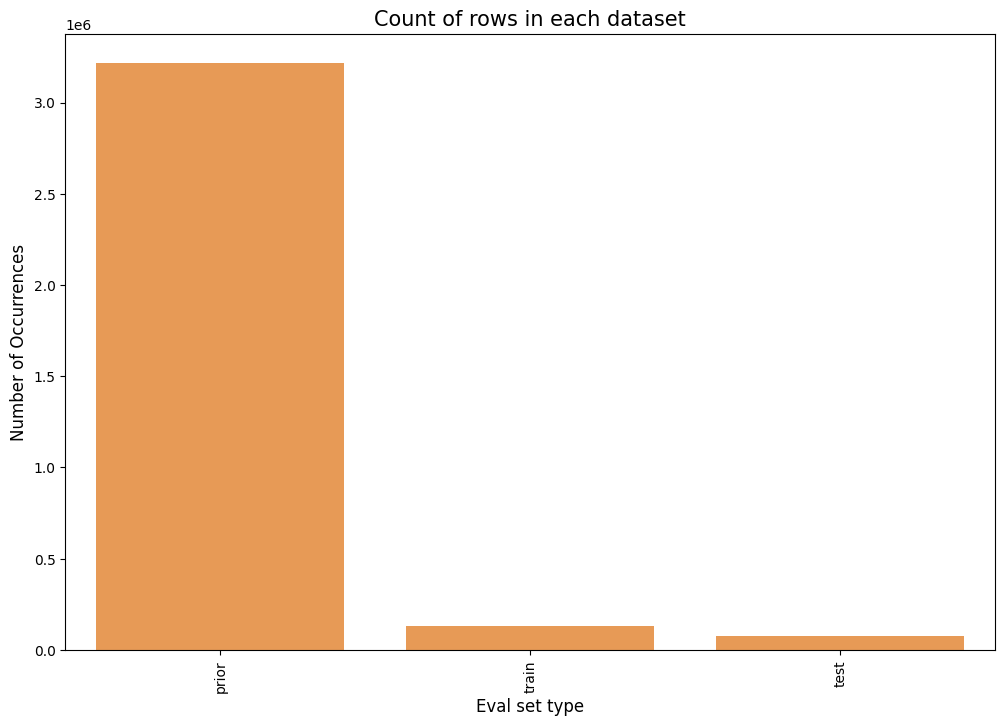

In [198]:
cnt_srs = orders_df.eval_set.value_counts() # orders_df의 eval_set 수 세기

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [199]:
def get_unique_count(x) :
    return len(np.unique(x)) # np.unique(x) : 중복된 값 제거

# orders_df을 eval_set로 그룹화하고 user_id의 수를 세기
cnt_srs = orders_df.groupby('eval_set')['user_id'].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

총 206,209의 customer가 있고 그 중 131,209의 고객은 train set 데이터에 있다
우리는 75,000의 고객을 예측해야한다

우리는 각 고객의 주문 수가 4에서 100 사이인지 검증해야 한다

/tmp/ipykernel_37/2873270471.py:3: FutureWarning: The provided callable <function max at 0x7aaa9d595480> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()


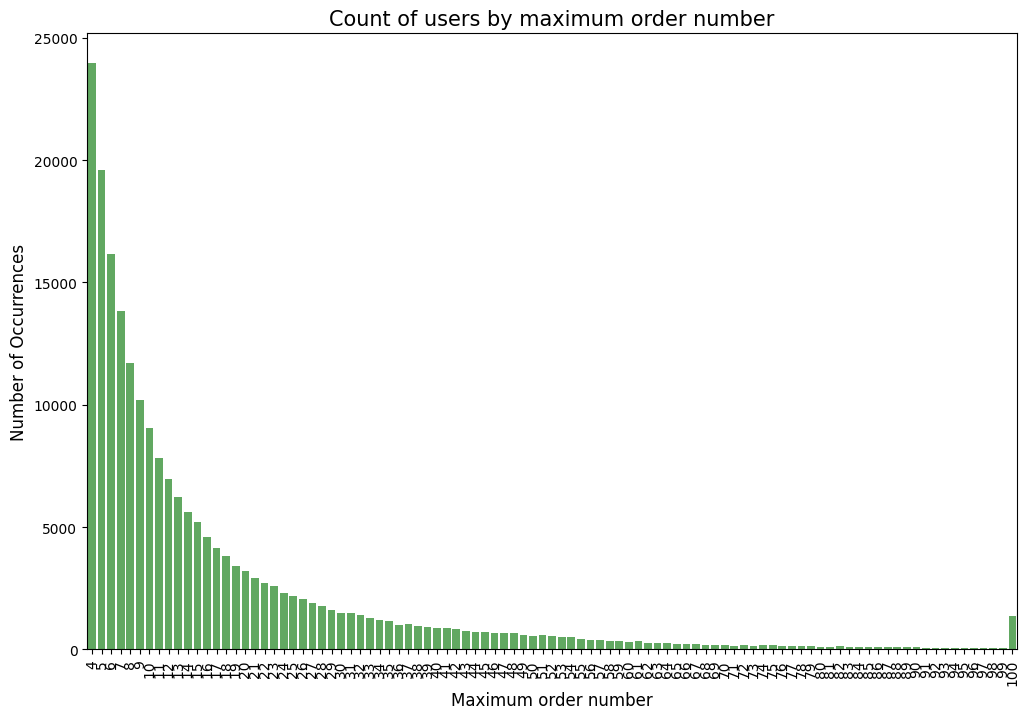

In [200]:
# 고객의 최대 주문 수

cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.title('Count of users by maximum order number', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

여기에는 4보다 작은 주문 수는 없고 상한이 100으로 한정되어 있음

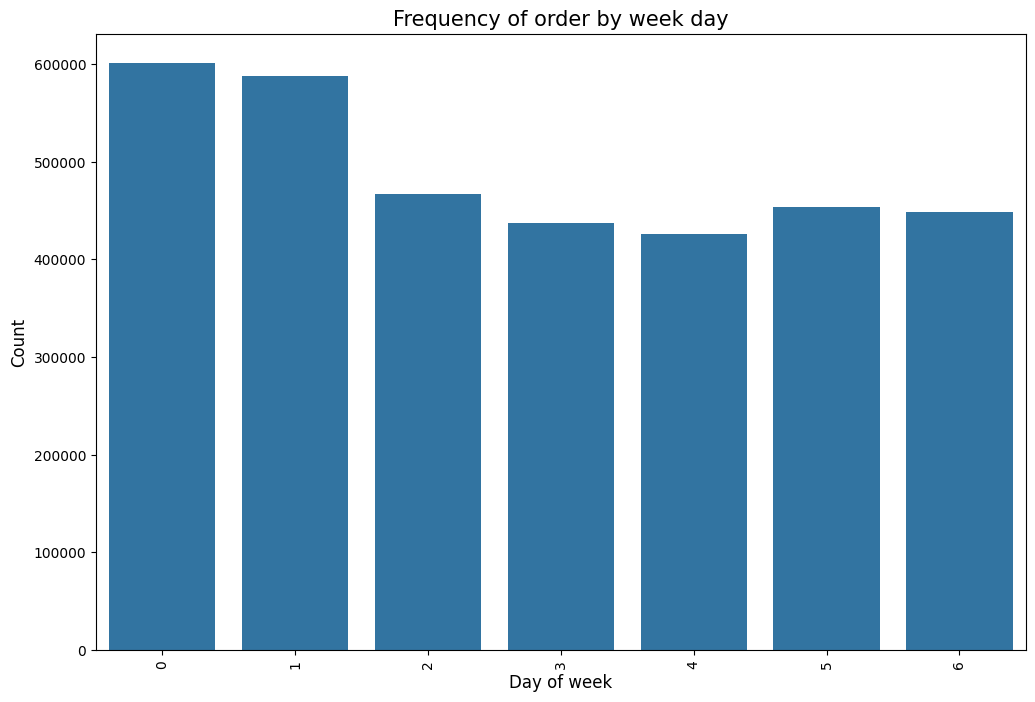

In [201]:
# 한 주의 날마다 주문 경향이 바뀌는 지 확인

plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
#Seaborn의 countplot 함수를 사용하여 'order_dow' 열의 값에 따라 주문 수를 세어 막대 그래프로 표시
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

0과 1은 주문수가 높으므로 토요일, 일요일

4인 수요일에 주문수 낮음

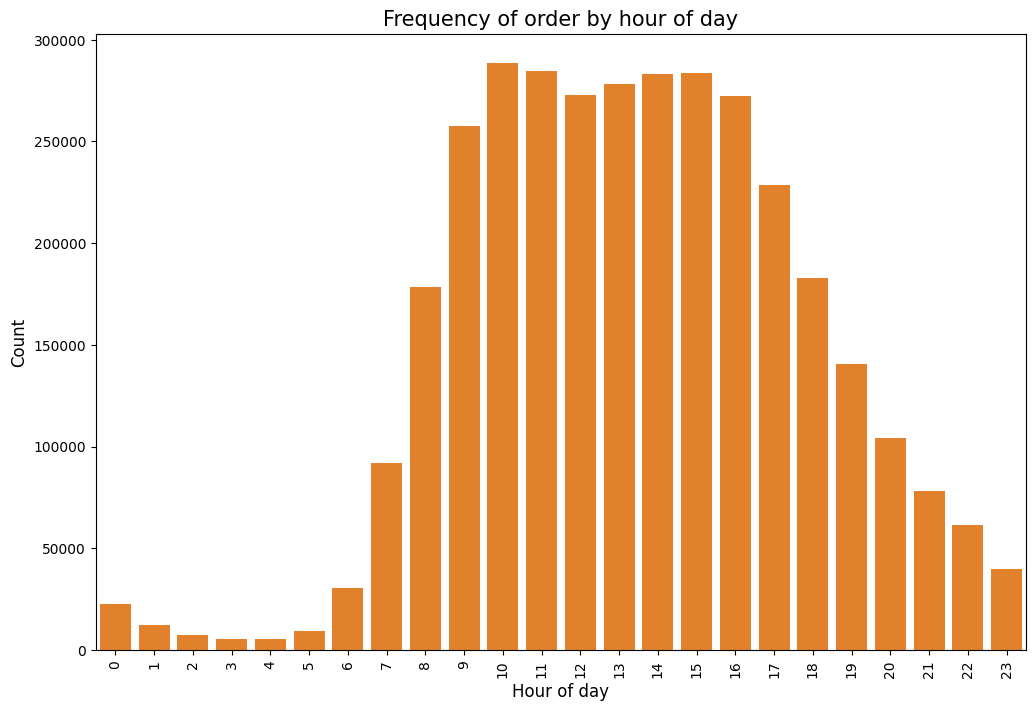

In [202]:
# 하루의 시간별로

plt.figure(figsize=(12,8))
sns.countplot(x='order_hour_of_day', data=orders_df, color=color[1])
# Seaborn의 countplot 함수를 사용하여 'order_hour_of_day' 열의 값에 따라 주문 수를 세어 막대 그래프로 표시
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

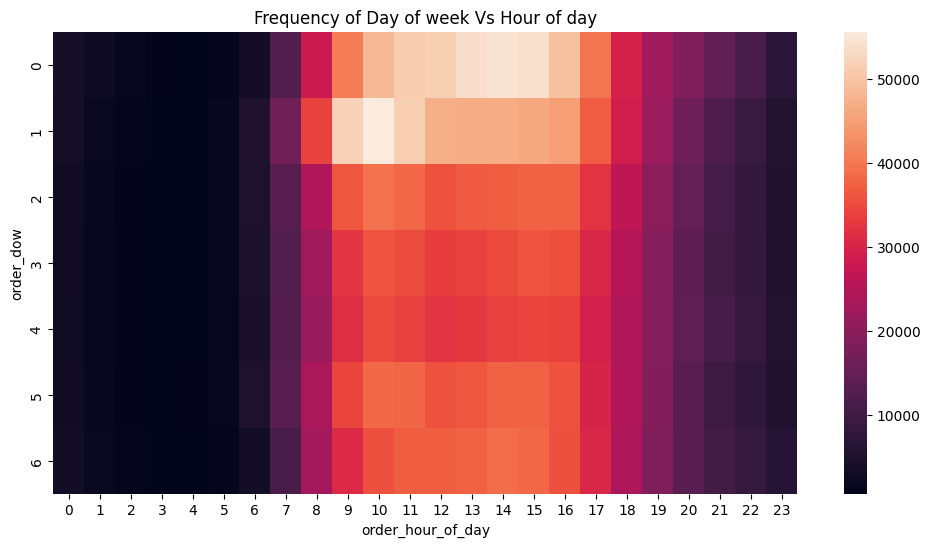

In [203]:
# 요일과 시간을 함께

grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
## orders_df를 'order_dow'(요일)와 'order_hour_of_day'(시간대) 기준으로 그룹화
## 각 그룹 내에서 'order_number'의 개수를 세기
## reset_index()는 결과를 데이터프레임으로 반환하며, 인덱스를 리셋합니다.

grouped_df = grouped_df.pivot(index = 'order_dow', columns = 'order_hour_of_day', values = 'order_number')
## grouped_df를 피벗하여 'order_dow'를 인덱스로, 'order_hour_of_day'를 열로 사용, 주문 수('order_number')를 값으로 사용
## 요일과 시간대에 따른 주문 수를 쉽게 시각화할 수 있는 형태로 변환

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

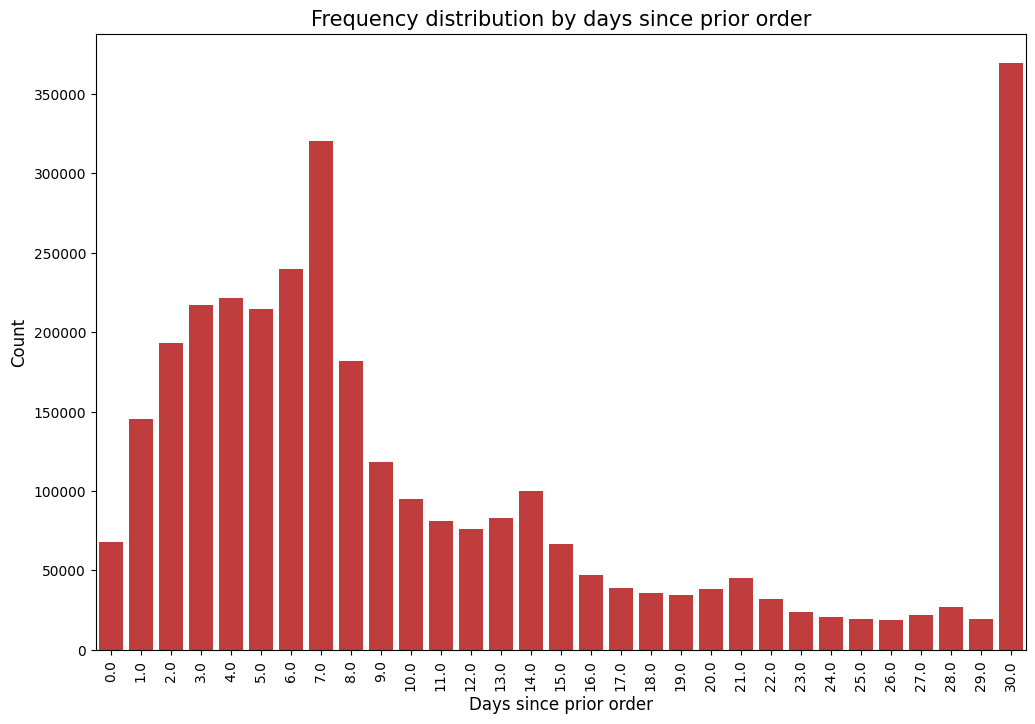

In [204]:
# 주문 사이의 시간 간격

plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])

plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

7일(매주), 30일(매달) 주문하는 경향을 보임, 14,21,28일에도 작은 피크를 보임

우리의 목표는 재주문을 규명하는 것이므로 prior set과 train set에서 재주문 확률을 확인하자

In [205]:
# percentage of re-orders in prior set (prior set에서 재주문 확률)
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]
## shape 속성은 데이터프레임의 크기를 나타냄. [0]는 행의 수를 반환하므로 전체 주문의 수를 나타냄

0.5904594330400782

In [206]:
# percentage of re-orders in train set (train set에서 재주문 확률)
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

평균적으로 물건의 59% 재주문 함

No re-ordered products 확인하기

In [207]:
# prior set에서

grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df.loc[grouped_df["reordered"] > 1, "reordered"] = 1
## reordered 값을 이진화
grouped_df["reordered"].value_counts() / grouped_df.shape[0]
## 재주문 확률

reordered
1    0.879472
0    0.120528
Name: count, dtype: float64

In [208]:
# train set에서

grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df.loc[grouped_df["reordered"] > 1, "reordered"] = 1
## reordered 값을 이진화
grouped_df["reordered"].value_counts() / grouped_df.shape[0]
## 재주문 확률

reordered
1    0.93444
0    0.06556
Name: count, dtype: float64

각 주문에서 구매된 제품의 수

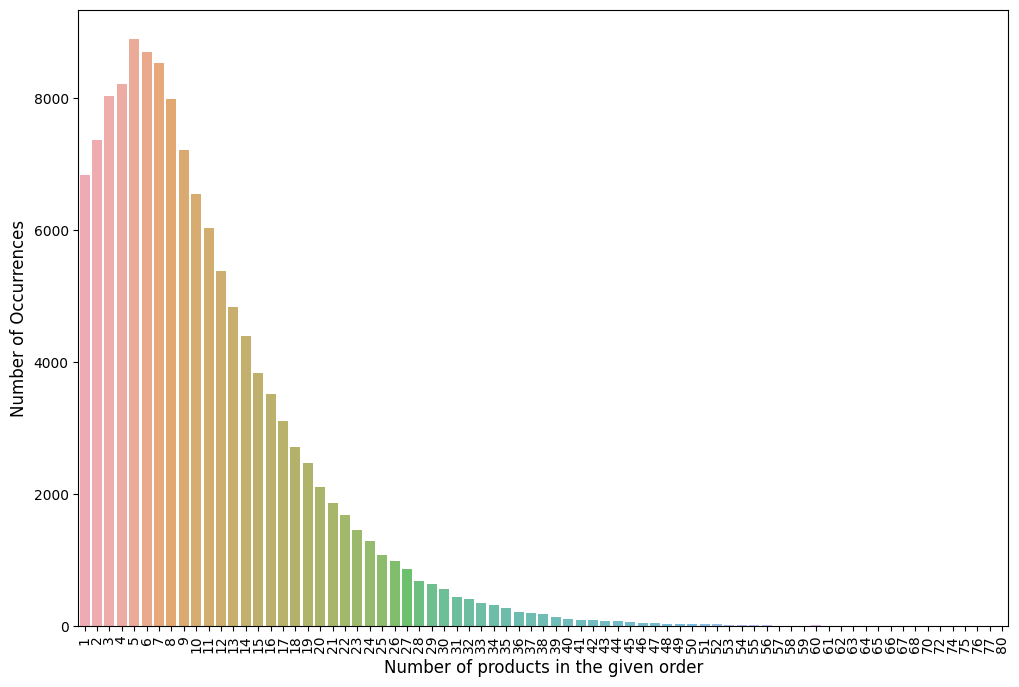

In [209]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## (2) 제품 관련 데이터 살펴보기

In [210]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [211]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [212]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [213]:
# 하나의 데이터로 합치기
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


Aisle 별로 살펴보기

In [214]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,15450
1,Bag of Organic Bananas,12409
2,Organic Strawberries,8528
3,Organic Baby Spinach,7852
4,Organic Hass Avocado,6857
5,Organic Avocado,5646
6,Large Lemon,4928
7,Strawberries,4587
8,Limes,4526
9,Organic Raspberries,4420


대부분이 organic 제품이며 그들 중 대부분이 과일

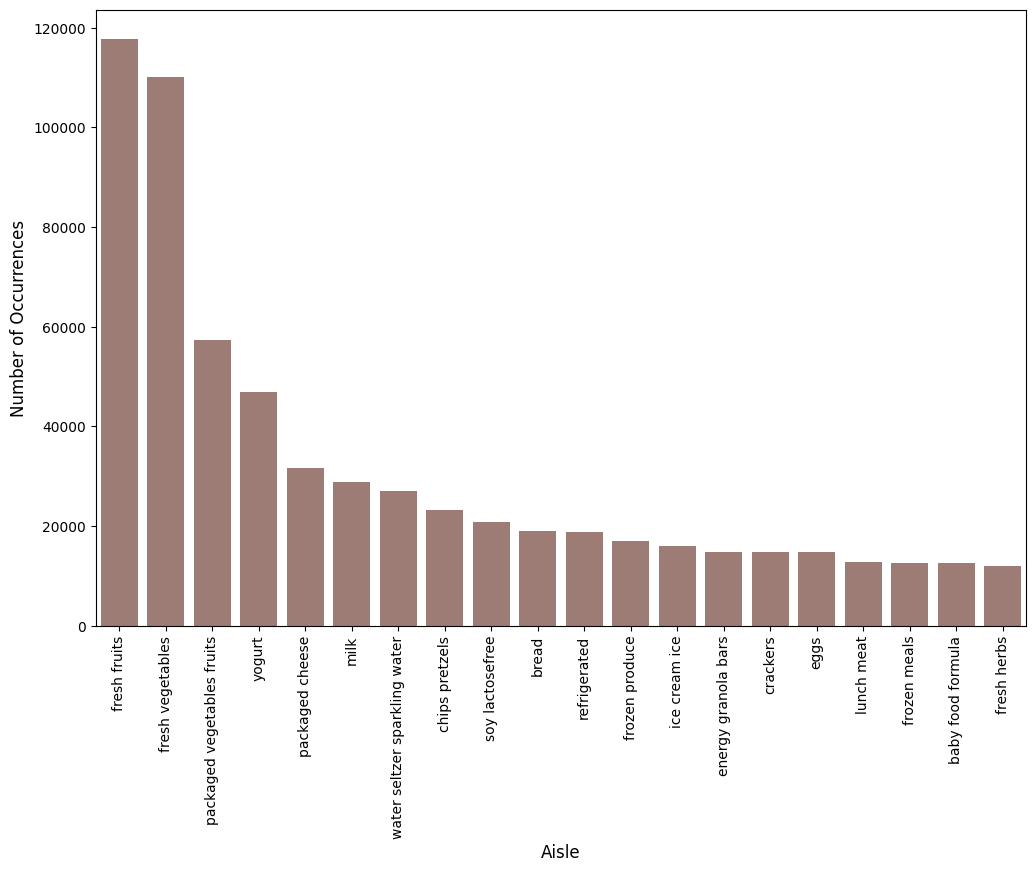

In [215]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)

plt.figure(figsize=(12,8))
sns.barplot(x = cnt_srs.index, y = cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Deparment 별로 살펴보기

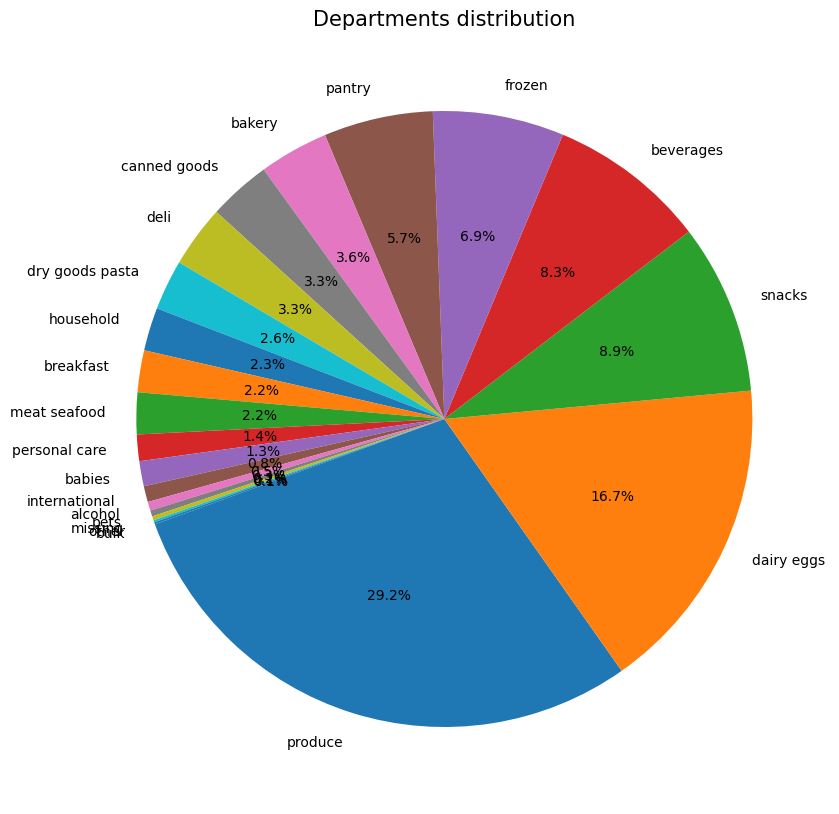

In [216]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()

labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

각 department 별 재주문 확률 계산

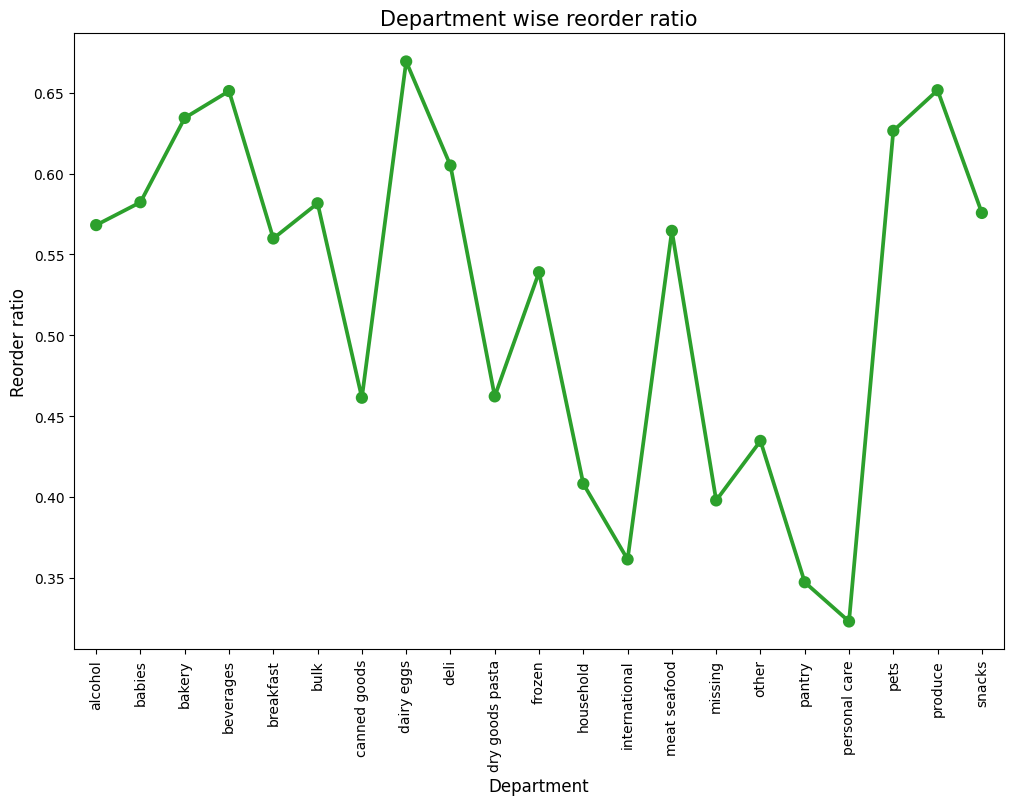

In [217]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x='department', y='reordered', data=grouped_df, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Aisle와 department 별 재주문 비율

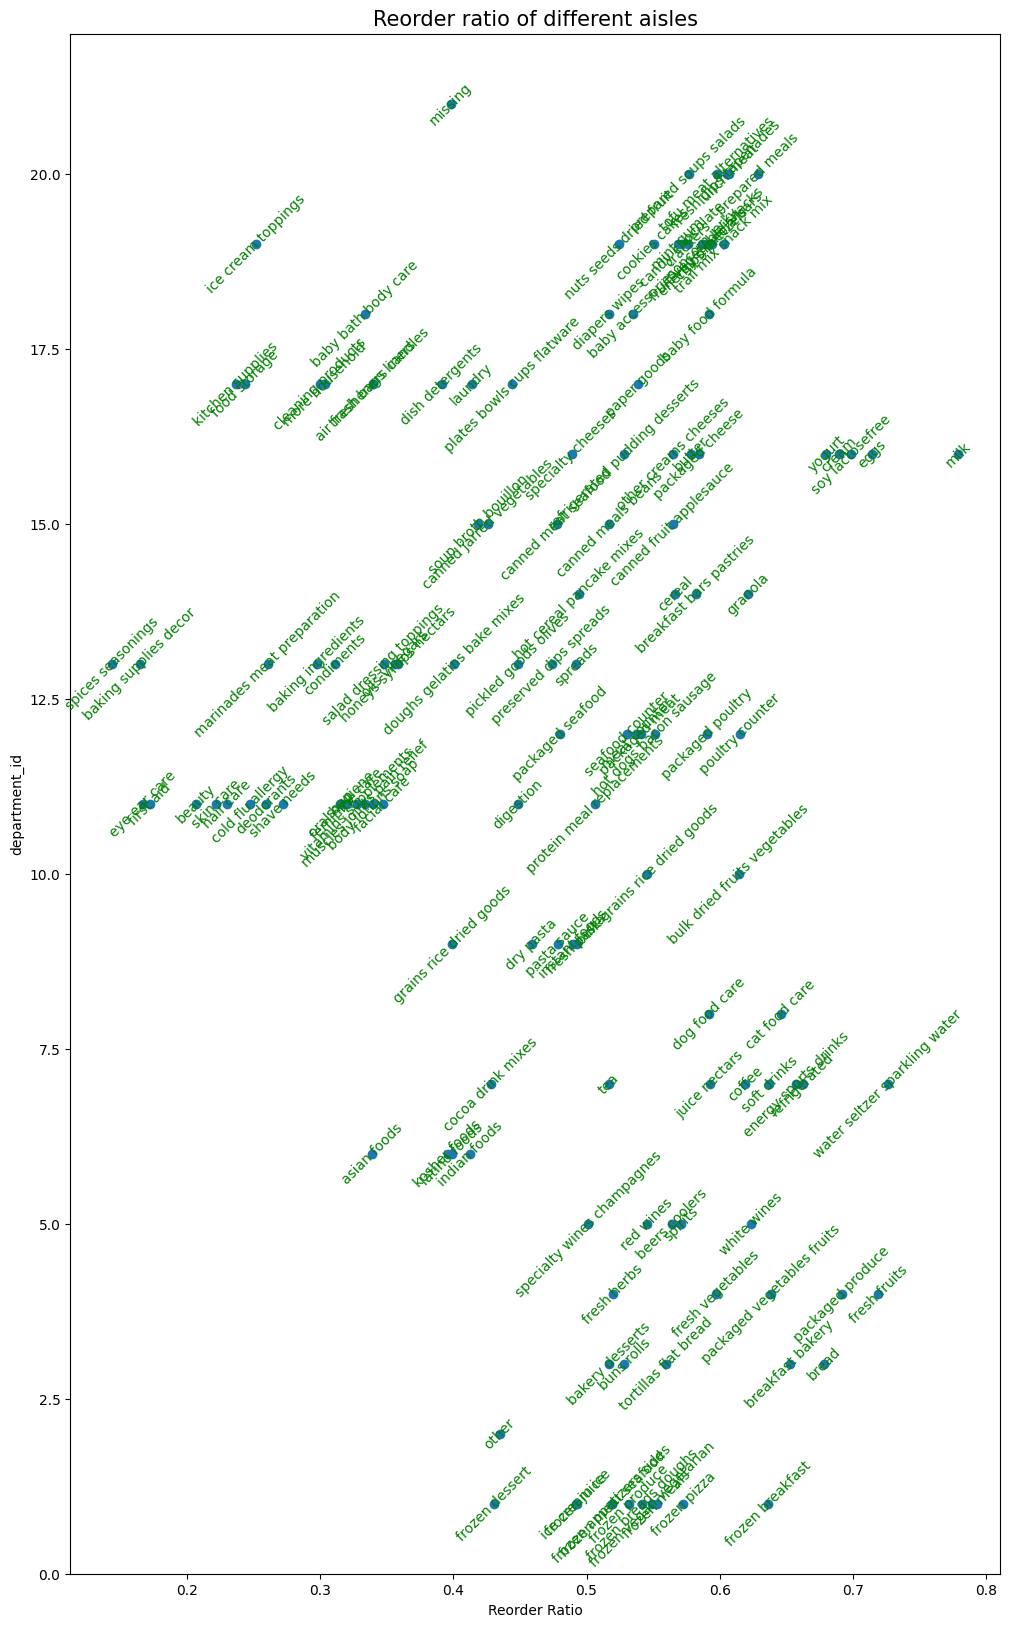

In [218]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')

plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

Add to Cart와 재주문 비율

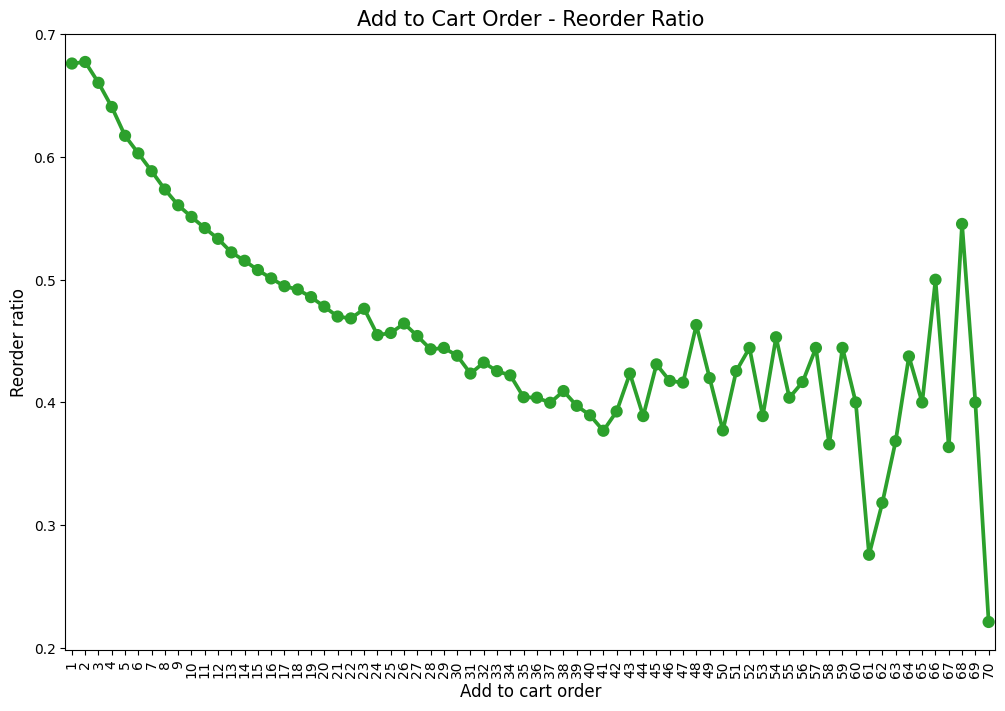

In [219]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df.loc[order_products_prior_df["add_to_cart_order_mod"] > 70, "add_to_cart_order_mod"] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x='add_to_cart_order_mod', y='reordered', data=grouped_df, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to Cart Order - Reorder Ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

시간에 따른 재주문 비율

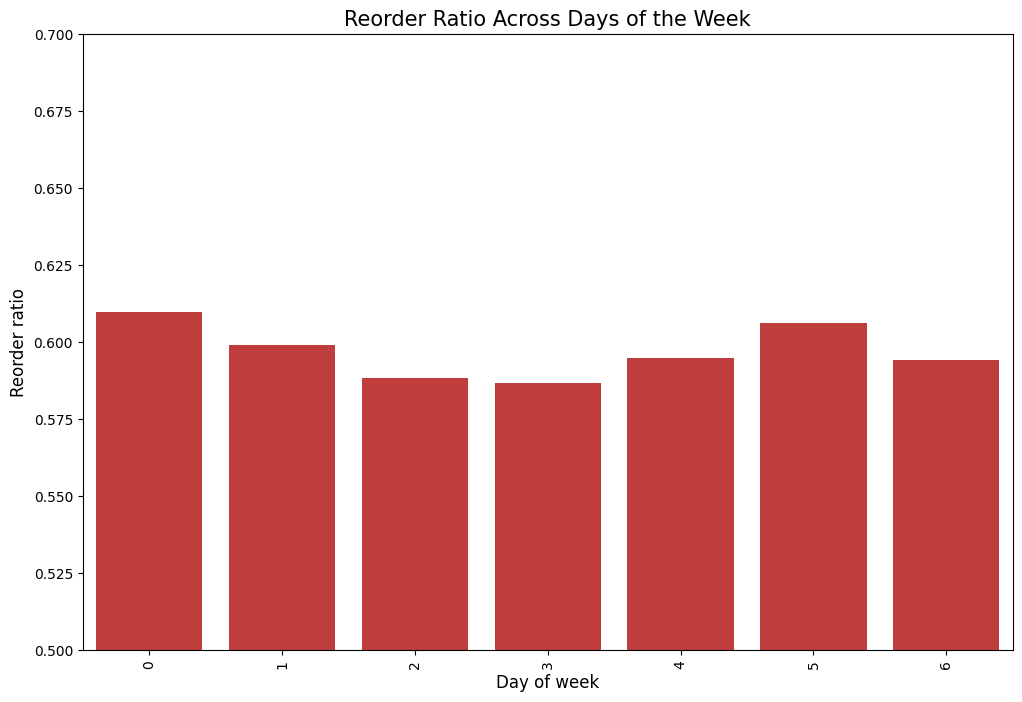

In [220]:
# 요일

order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='order_dow', y='reordered', data=grouped_df, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder Ratio Across Days of the Week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

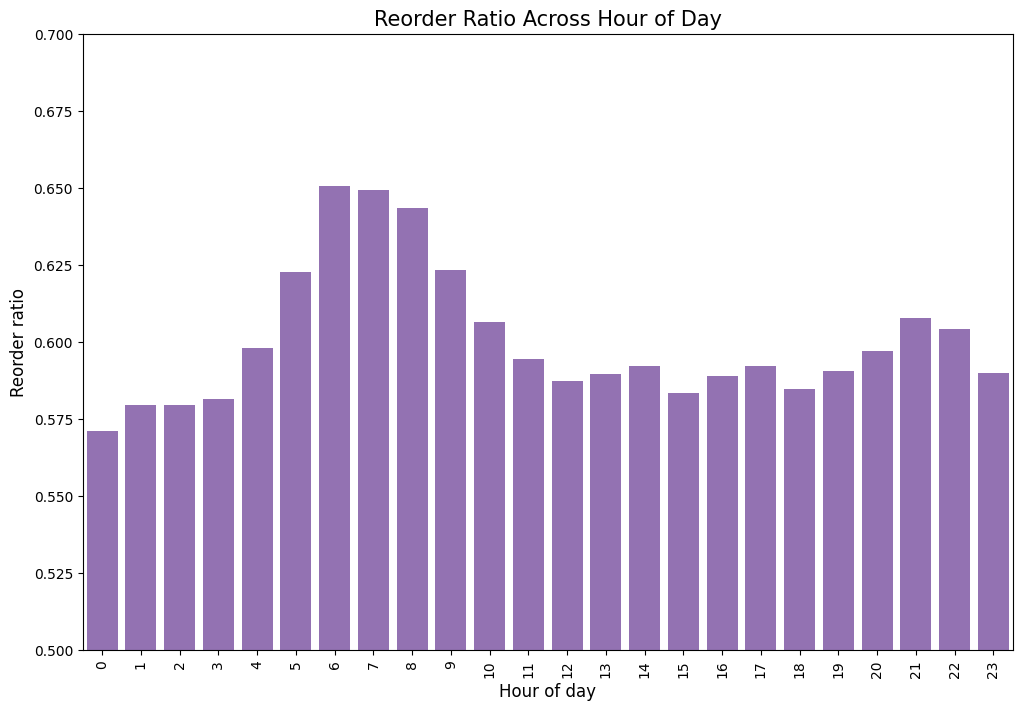

In [221]:
# 하루 중 시간

grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='order_hour_of_day', y='reordered', data=grouped_df, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder Ratio Across Hour of Day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

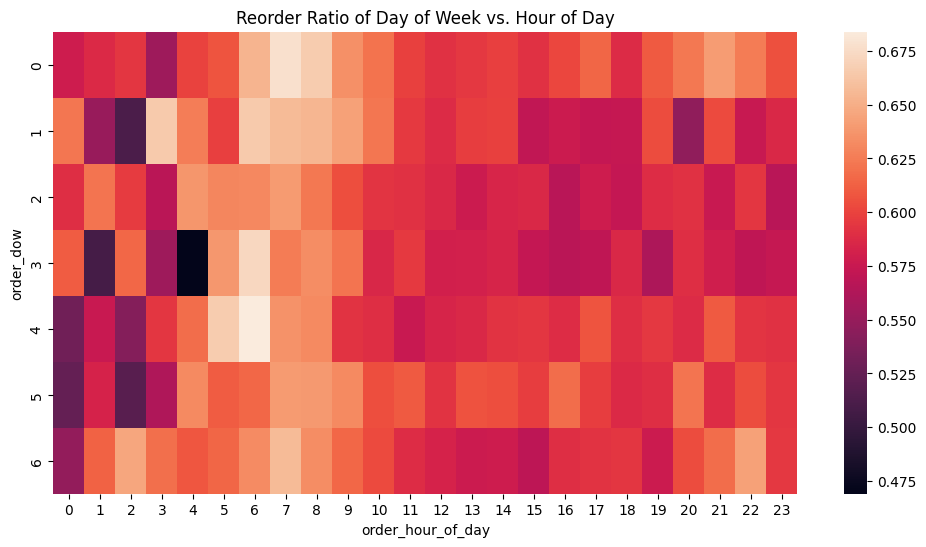

In [222]:
# 주문한 시간과 요일

grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day', values='reordered')

plt.figure(figsize=(12, 6))
sns.heatmap(grouped_df)
plt.title("Reorder Ratio of Day of Week vs. Hour of Day")
plt.show()

## 새로운 전처리/시각화

시간에 따른 판매 제품

주말과 평일간 차이

In [223]:
order_products_train_df = pd.read_csv("../input/data-instacart/order_products__train.csv")
order_products_prior_df = pd.read_csv("../input/data-instacart/order_products__prior.csv")
orders_df = pd.read_csv("../input/data-instacart/orders.csv")
products_df = pd.read_csv("../input/data-instacart/products.csv")
aisles_df = pd.read_csv("../input/data-instacart/aisles.csv")
departments_df = pd.read_csv("../input/data-instacart/departments.csv")

In [224]:
order_products_train_df = pd.merge(order_products_train_df, products_df, on='product_id', how='left')
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
order_products_trian_df = pd.merge(order_products_train_df, aisles_df, on='aisle_id', how='left')
order_products_train_df = pd.merge(order_products_train_df, departments_df, on='department_id', how='left')

order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,4,10,9.0,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,112108,train,4,4,10,9.0,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,112108,train,4,4,10,9.0,produce
3,1,49683,4,0,Cucumber Kirby,83,4,112108,train,4,4,10,9.0,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,112108,train,4,4,10,9.0,canned goods


In [225]:
print(order_products_train_df['order_dow'].dtype)

# order_dow를 정수형으로 변환
order_products_train_df['order_dow'] = pd.to_numeric(order_products_train_df['order_dow'], errors='coerce')

int64


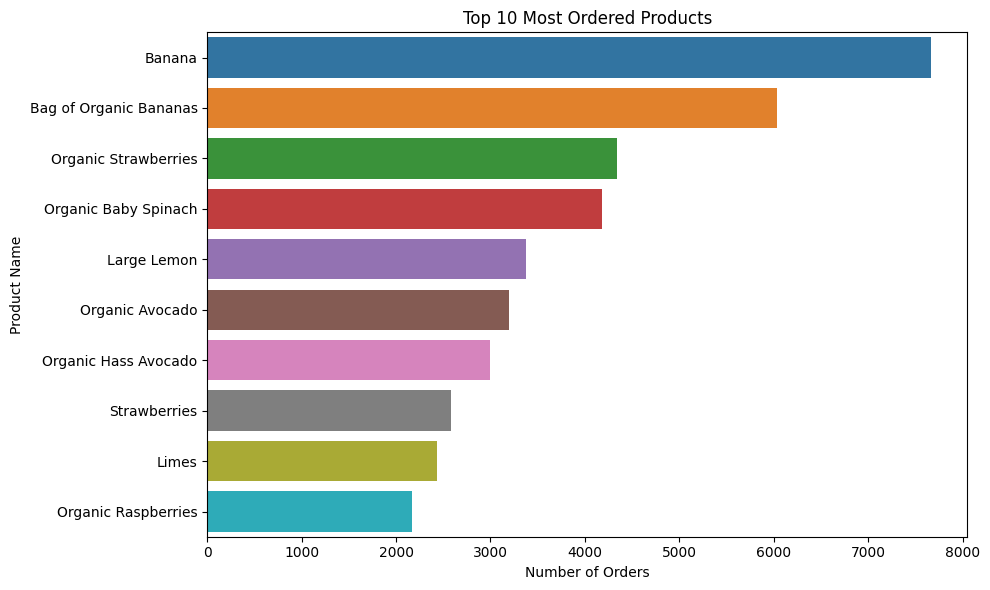

In [226]:
# 주말에 많이 판매되는 제품

product_weekend_df = order_products_train_df[order_products_train_df['order_dow'].isin([0, 1])]

product_counts_df = product_weekend_df['product_name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=product_counts_df.values, y=product_counts_df.index)
plt.title('Top 10 Most Ordered Products')
plt.xlabel('Number of Orders')
plt.ylabel('Product Name')
plt.tight_layout()

plt.show()

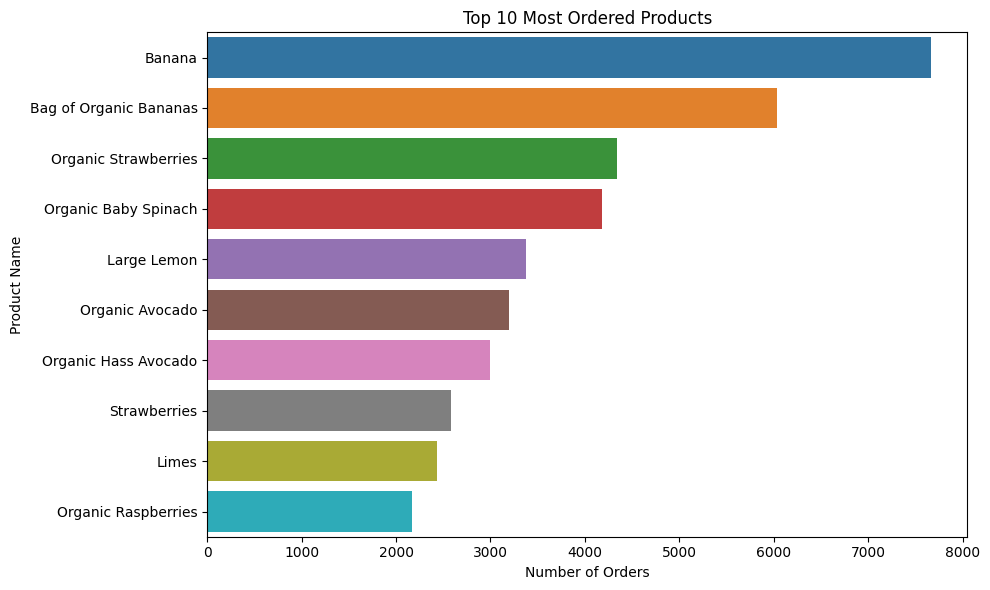

In [227]:
# 평일에 많이 판매되는 제품

product_weekday_df = order_products_train_df[order_products_train_df['order_dow'].isin([0, 1])]

product_counts_df = product_weekday_df['product_name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=product_counts_df.values, y=product_counts_df.index)
plt.title('Top 10 Most Ordered Products')
plt.xlabel('Number of Orders')
plt.ylabel('Product Name')
plt.tight_layout()

plt.show()

가장 많이 팔린 제품의 주말과 평일간 판매량 차이

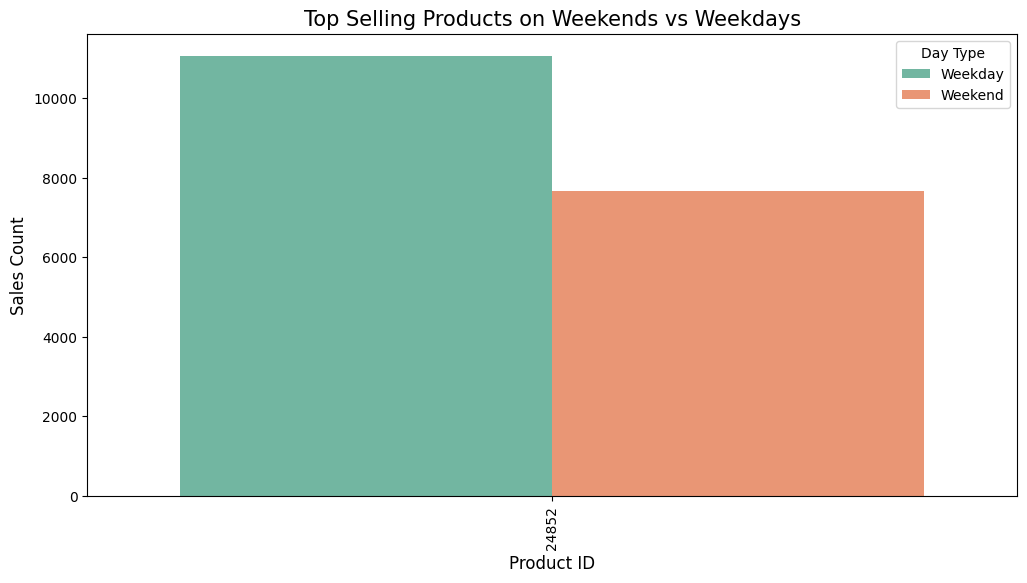

In [228]:
# 주말과 평일 구분
order_products_train_df['day_type'] = order_products_train_df['order_dow'].apply(lambda x: 'Weekend' if x < 2 else 'Weekday')

# 각 날 타입별 제품 판매량 집계
product_sales = order_products_train_df.groupby(['day_type', 'product_id'])['add_to_cart_order'].count().reset_index()
product_sales = product_sales.rename(columns={'add_to_cart_order': 'sales_count'})

# 가장 많이 판매된 제품 추출
top_products = product_sales.loc[product_sales.groupby('day_type')['sales_count'].idxmax()]

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products, x='product_id', y='sales_count', hue='day_type', palette='Set2')
plt.ylabel('Sales Count', fontsize=12)
plt.xlabel('Product ID', fontsize=12)
plt.title('Top Selling Products on Weekends vs Weekdays', fontsize=15)
plt.xticks(rotation=90)
plt.legend(title='Day Type')
plt.show()


가장 많이 팔린 제품의 판매량은 평일이 더 높다는 것을 알 수 있다.

오전과 오후의 차이

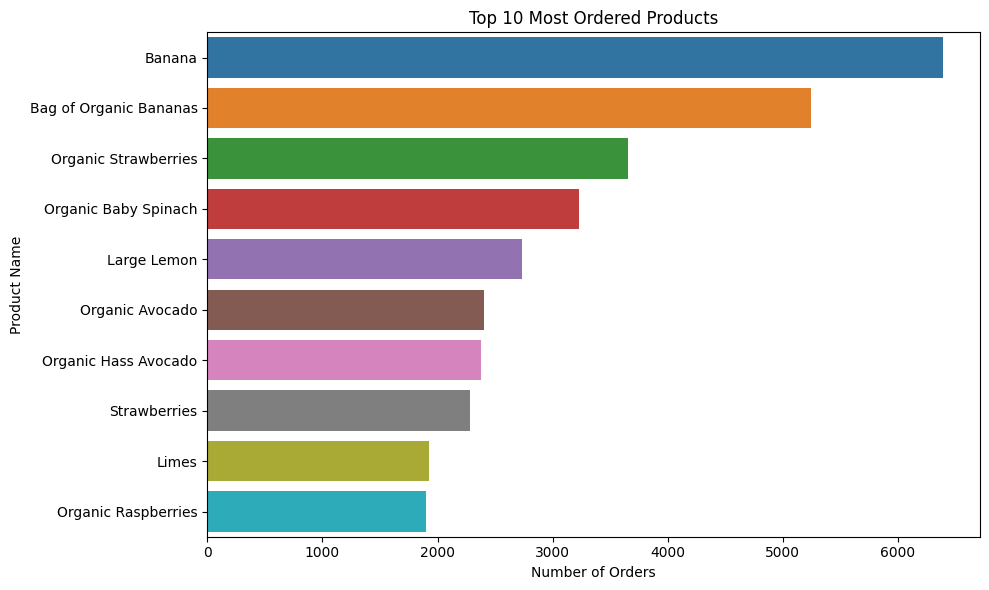

In [229]:
product_daytime_df = order_products_train_df[(order_products_train_df['order_hour_of_day'] < 12)]

product_counts_df = product_daytime_df['product_name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=product_counts_df.values, y=product_counts_df.index)
plt.title('Top 10 Most Ordered Products')
plt.xlabel('Number of Orders')
plt.ylabel('Product Name')
plt.tight_layout()

plt.show()

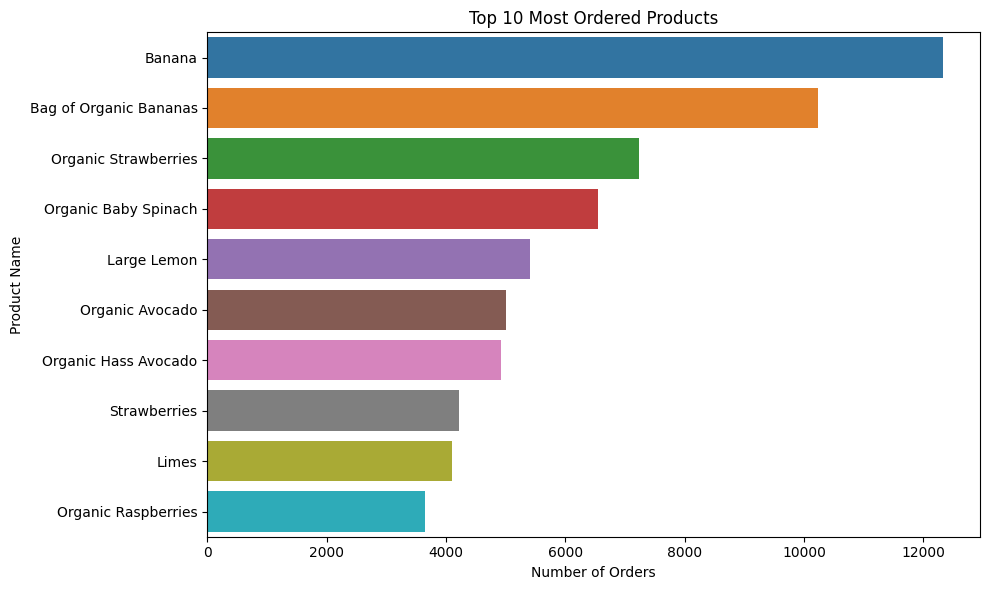

In [230]:
product_nighttime_df = order_products_train_df[(order_products_train_df['order_hour_of_day'] >= 12)]

product_counts_df = product_nighttime_df['product_name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=product_counts_df.values, y=product_counts_df.index)
plt.title('Top 10 Most Ordered Products')
plt.xlabel('Number of Orders')
plt.ylabel('Product Name')
plt.tight_layout()

plt.show()

가장 많이 팔린 제품의 오전과 오후간 판매량 차이

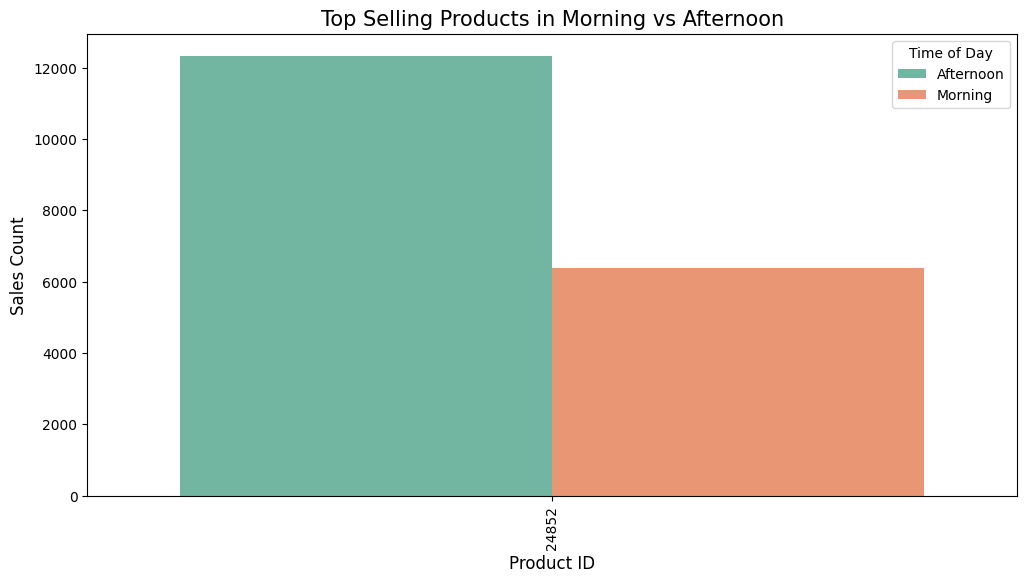

In [231]:
# 시간대 분류
order_products_train_df['time_of_day'] = order_products_train_df['order_hour_of_day'].apply(lambda x: 'Morning' if x < 12 else 'Afternoon')

# 각 시간대별 제품 판매량 집계
product_sales = order_products_train_df.groupby(['time_of_day', 'product_id'])['add_to_cart_order'].count().reset_index()
product_sales = product_sales.rename(columns={'add_to_cart_order': 'sales_count'})

# 가장 많이 판매된 제품 추출
top_products = product_sales.loc[product_sales.groupby('time_of_day')['sales_count'].idxmax()]

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=top_products, x='product_id', y='sales_count', hue='time_of_day', palette='Set2')
plt.ylabel('Sales Count', fontsize=12)
plt.xlabel('Product ID', fontsize=12)
plt.title('Top Selling Products in Morning vs Afternoon', fontsize=15)
plt.xticks(rotation=90)
plt.legend(title='Time of Day')
plt.show()
